$D_t U=-10 D_x^2 U - 0.1 D_x^4 U + 10 D_x^2 U^3$

In [1]:
import matplotlib.pyplot as plt

# General imports
import numpy as np
import torch

# DeePyMoD imports
from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.data.burgers import burgers_delta
from deepymod.model.constraint import LeastSquares
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D
from deepymod.model.sparse_estimators import Threshold
from deepymod.training import train
from deepymod.training.sparsity_scheduler import Periodic, TrainTest, TrainTestPeriodic
from scipy.io import loadmat
import pysindy as ps

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


In [2]:
def load_data():
    data = loadmat("../../PDE-READ/Matlab/Data/Cahn_Hilliard_Sine.mat")
    time = np.ravel(data["t"]).squeeze()
    x = np.ravel(data["x"]).squeeze()
    array = {}
    array["x"], array["t"] = np.meshgrid(x, time, indexing="ij")
    array["u"] = data["usol"]
    array["x"].shape, array["t"].shape, array["u"].shape
    coords = torch.from_numpy(np.stack((array["t"],array["x"]), axis=-1)).float()
    data = torch.from_numpy(np.real(array["u"])).unsqueeze(-1).float()
    return coords, data

In [3]:
dataset = Dataset(
    load_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 300000},
    device=device,
)

Preprocessing data
Dataset is using device:  cuda


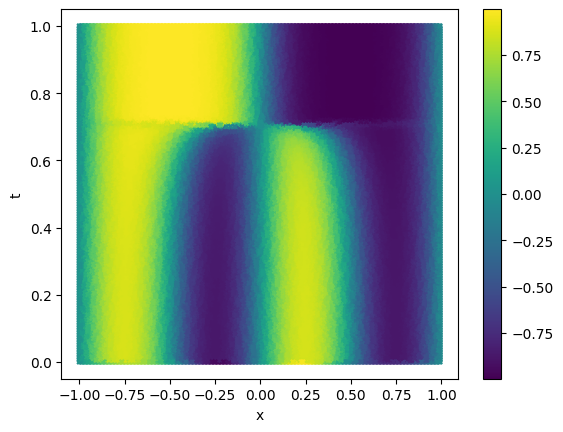

In [4]:
coords = dataset.get_coords().cpu()
data = dataset.get_data().cpu()
fig, ax = plt.subplots()
im = ax.scatter(coords[:,1], coords[:,0], c=data[:,0], marker="x", s=10)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)

plt.show()

In [5]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

In [6]:
network = NN(2, [30, 30, 30, 30], 1)

In [7]:
library = Library1D(poly_order=3, diff_order=4) 

In [8]:
estimator = Threshold(0.1) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5) 

In [9]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

In [10]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) 


In [11]:
%%time
!rm -rf ./data/deepymod/Cahn_Hilliard/
foldername = "./data/deepymod/Cahn_Hilliard/"
train(model, 
train_dataloader, 
test_dataloader, 
optimizer,
sparsity_scheduler, 
log_dir=foldername, 
split=0.8, 
max_iterations=100000) 

 99975  MSE: 9.02e-03  Reg: 7.33e-04  L1: 3.38e+01 Algorithm converged. Writing model to disk.
CPU times: user 3h 4min 7s, sys: 1min 29s, total: 3h 5min 36s
Wall time: 3h 4min 16s


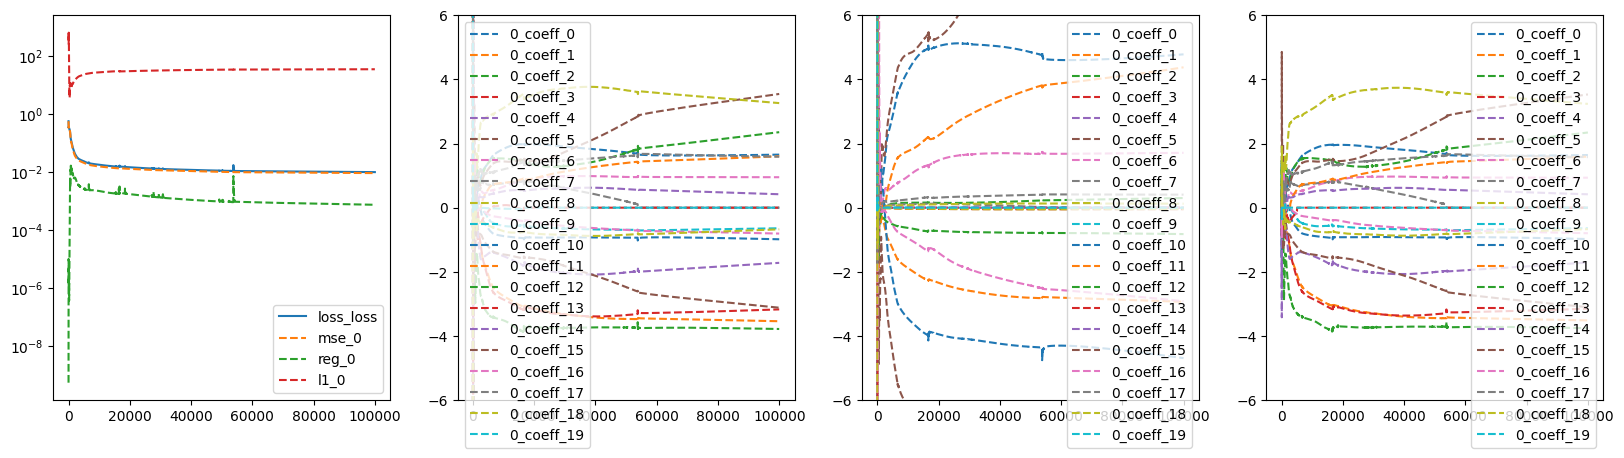

In [15]:
from deepymod.analysis import load_tensorboard
history = load_tensorboard(foldername) 
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for history_key in history.keys():
    history_key_parts = history_key.split("_")
    if history_key_parts[0] == "loss":    
        if history_key_parts[-1] == "0":
            axs[0].semilogy(history[history_key], label=history_key_parts[1]+"_"+history_key_parts[-1], linestyle="--")
        elif history_key_parts[-1] == "1":
            axs[0].semilogy(history[history_key],  label=history_key_parts[1]+"_"+history_key_parts[-1], linestyle=":")
        else:
            axs[0].semilogy(history[history_key],  label=history_key_parts[1]+"_"+history_key_parts[-1], linestyle="-")
        if history_key_parts[0] == "remaining":    
            axs[0].semilogy(history[history_key],  label=history_key_parts[1]+"_"+history_key_parts[3]+"_"+history_key_parts[4], linestyle="-.")
    if history_key_parts[0] == "coeffs":
        if history_key_parts[2] == "0":
            axs[1].plot(history[history_key], label=history_key_parts[2]+"_"+history_key_parts[3]+"_"+history_key_parts[4], linestyle="--")
        elif history_key_parts[2] == "1":
            axs[1].plot(history[history_key], label=history_key_parts[2]+"_"+history_key_parts[3]+"_"+history_key_parts[4], linestyle=":")
        else:
            axs[1].plot(history[history_key], label=history_key_parts[2]+"_"+history_key_parts[3]+"_"+history_key_parts[4], linestyle="-")
    if history_key_parts[0] == "unscaled":    
        if history_key_parts[3] == "0":
            axs[2].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle="--")
        elif history_key_parts[3] == "1":
            axs[2].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle=":")
        else:
            axs[2].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle="-")
    if history_key_parts[0] == "estimator":    
        if history_key_parts[3] == "0":
            axs[3].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle="--")
        elif history_key_parts[3] == "1":
            axs[3].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle=":")
        else:
            axs[3].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle="-")

#axs[0].set_ylim([-2, 2])
axs[1].set_ylim([-6, 6])
axs[2].set_ylim([-6, 6])
axs[3].set_ylim([-6, 6])

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

plt.show()


In [16]:
model.constraint_coeffs()

[tensor([[ 4.7798e+00],
         [-2.9329e+00],
         [ 3.0118e-01],
         [-4.8439e-02],
         [-2.1457e-03],
         [ 1.4538e+01],
         [ 1.7101e+00],
         [ 0.0000e+00],
         [ 1.2438e-01],
         [-1.5869e-03],
         [-4.6891e+00],
         [ 4.3756e+00],
         [-8.2266e-01],
         [ 0.0000e+00],
         [ 1.6580e-03],
         [-1.6066e+01],
         [-2.9166e+00],
         [ 4.0675e-01],
         [-4.3225e-02],
         [ 0.0000e+00]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]

In [17]:
model.estimator_coeffs()

[array([[ 1.641378  ],
        [-3.5128155 ],
        [ 2.3438122 ],
        [-3.148204  ],
        [-1.7094363 ],
        [ 3.5301223 ],
        [ 0.93416643],
        [ 0.        ],
        [ 3.2348285 ],
        [-0.6368615 ],
        [-0.97697353],
        [ 1.592245  ],
        [-3.7554145 ],
        [ 0.        ],
        [ 0.41745803],
        [-3.101124  ],
        [-0.7959328 ],
        [ 1.5770061 ],
        [-0.66903263],
        [ 0.        ]], dtype=float32)]